# Hierarchical pendulum SBI, using a csv of (theta, x)

## The dataset: simple static pendulum
Using the position of a pendulum at one point in time from a collection of pendulums on two different planets, determine the position associated with L, $\theta$, and $a_g$ using a deep ensemble.

In [4]:
## first, import all the necessary modules
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
#from src.scripts import utils
import numpyro

In [5]:
import deepbench
from deepbench.physics_object import Pendulum
print(deepbench.__version__)

0.2.01


In [6]:
import sbi
from sbi import utils, inference, analysis
# from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
from sbi.inference.base import infer
import torch

In [7]:
# this is necessary to import modules from this repo
import sys
sys.path.append('..')
from src.scripts import models, utils, train

In [11]:
from numpyro.util import enable_x64

enable_x64()

import jax.numpy as jnp
import jax
rng_key = jax.random.PRNGKey(0)
print(rng_key)

[0 0]


## Prepare dataframe that associates (theta, x)
Here, I run a quick simulation that grid-searches all the theta values.

In [39]:
def save_thetas_and_xs_single(thetas_in):
    # except length will have 8 elements as will theta
    length, theta, μ_a_g, σ_a_g = thetas_in

    a_g = rs.normal(loc=μ_a_g, scale=σ_a_g)
    #numpyro.sample("a_g", numpyro.distributions.TruncatedNormal(float(μ_a_g), float(σ_a_g), low = 0.01))
    #rng_key = jax.random.PRNGKey(1)  # You can use any valid random key
    #a_g_1 = numpyro.sample("a_g", numpyro.distributions.TruncatedNormal(float(μ_a_g), float(σ_a_g), low = 0.01), rng_key = rng_key)

    #a_g = [a_g_0, a_g_1]
    #print('a_g', a_g)
    
    
    pendulum = Pendulum(
                pendulum_arm_length=float(length),
                starting_angle_radians=float(theta),
                acceleration_due_to_gravity=float(a_g),
                noise_std_percent={
                    "pendulum_arm_length": 0.0,
                    "starting_angle_radians": 0.1,
                    "acceleration_due_to_gravity": 0.0,
                },
            )
    x = pendulum.create_object(0.75, noiseless=False)
    del pendulum
    return a_g, x

In [7]:
# set priors for all of these things

In [8]:
# okay now make a dataframe with a bunch of different options for the parameters
# generate the L, theta, a_g values somewhat randomly between ranges
length_percent_error_all = 0.0
theta_percent_error_all = 0.1
a_g_percent_error_all = 0.0
pos_err = 0.0

time = 0.75

length_df = 1000
thetas = np.zeros((length_df, 5))
# this needs to have the extra 1 so that SBI is happy
xs = np.zeros((length_df,1))
#labels = np.zeros((2*length_df, 2))
#error = []
#y_noisy = []

for r in range(length_df):
    
    rs = np.random.RandomState()#2147483648)# 
    
    
    length = abs(rs.normal(loc=5, scale=2))
    theta = abs(rs.normal(loc=jnp.pi/100, scale=jnp.pi/500))
    #length, theta, μ_a_g, σ_a_g = thetas_in
    μ_a_g = abs(rs.normal(loc=10, scale=2))
    σ_a_g = abs(rs.normal(loc=1, scale=0.5))
    

    thetas_in = [length, theta, μ_a_g, σ_a_g]

    a_g, x = save_thetas_and_xs_single(thetas_in, rs)
        
    
    thetas[r,:] = [length, theta, a_g, μ_a_g, σ_a_g]
    xs[r,:] = x
    #labels[r,:] = [0, r]
    
    
    

    


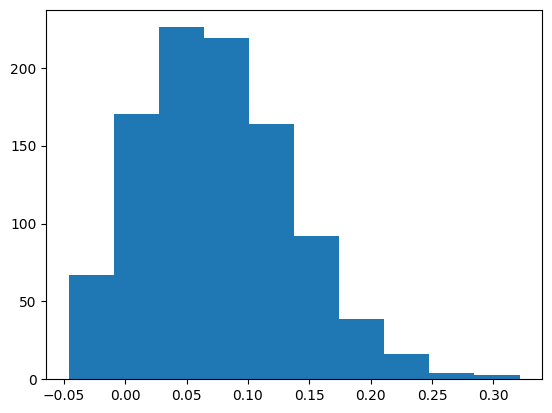

In [9]:
plt.clf()
plt.hist(xs)
plt.show()

## Eventually, we need to save this data

In [17]:


# make a fake prior
# L, theta_0, a_g, mu, sigma

'''
length = abs(rs.normal(loc=5, scale=2))
    theta = abs(rs.normal(loc=jnp.pi/100, scale=jnp.pi/500))
    #length, theta, μ_a_g, σ_a_g = thetas_in
    μ_a_g = abs(rs.normal(loc=10, scale=2))
    σ_a_g = abs(rs.normal(loc=1, scale=0.5))
'''
prior_low = [0, jnp.pi / 1000, 0, 0, 0]
prior_high = [10, jnp.pi / 10, 20, 20, 4]

prior = sbi.utils.BoxUniform(low=torch.tensor(prior_low), high=torch.tensor(prior_high), device='cpu')

posterior = train.train_SBI_hierarchical(thetas, xs, prior)

 Neural network successfully converged after 133 epochs.

In [51]:
print(posterior)

Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [52]:
# gotta simulate
L_true = 5
theta_not_true = jnp.pi / 100
mu_true = 10
sigma_true = 1

thetas_in = [L_true, theta_not_true, mu_true, sigma_true]

a_g_true, x_true = save_thetas_and_xs_single(thetas_in, rng_key)
thetas_true = [L_true, theta_not_true, a_g_true, mu_true, sigma_true]

In [53]:
# gotta sample from the posterior
samples = posterior.set_default_x(x_true).sample((10000,))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [54]:
print(np.shape(samples))

torch.Size([10000, 5])


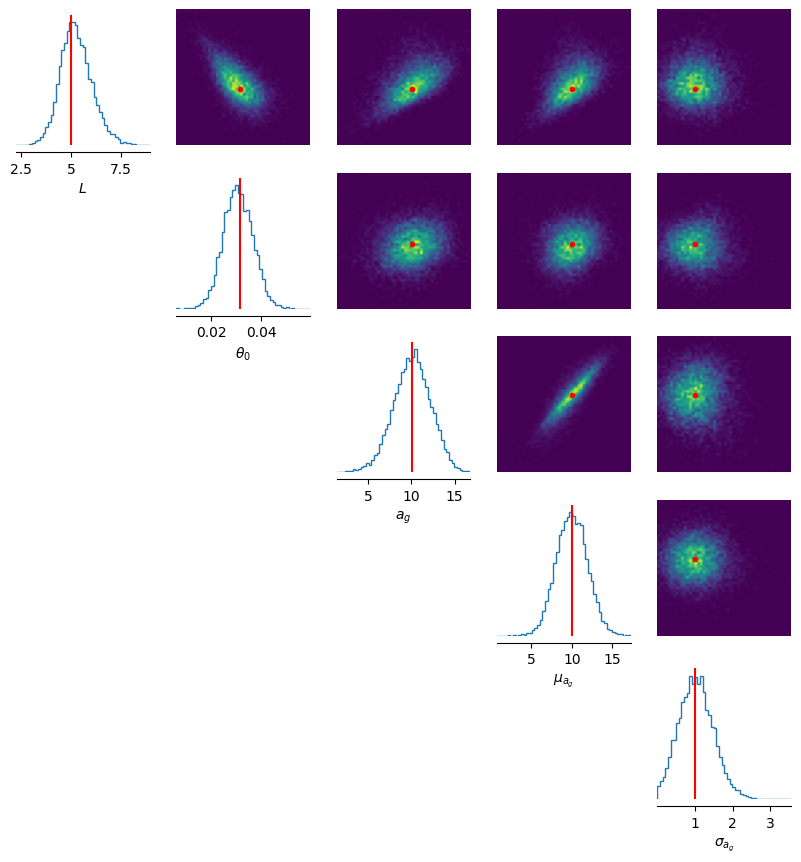

In [55]:
# Let's plot a corner plot.
fig, ax = sbi.analysis.pairplot(samples.cpu(),
                   points=[thetas_true],
                   labels=[r'$L$',r'$\theta_0$',r'$a_g$',r'$\mu_{a_g}$',r'$\sigma_{a_g}$'],
                   #limits=limits,
                   points_colors=['r','b'],
                   points_offdiag={'markersize': 6},
                   fig_size=[12, 12])

plt.show()

## What about saving multiple rows of data at once
So above, we saved one pendulum at a time with conditional $a_g$ values. How does this differ from saving 8 pendulums at once, four from each planet?

In [15]:
def save_thetas_and_xs_multiple(thetas_in):
    # except length will have 4 elements
    length0, length1, length2, length3, theta0, theta1, theta2, theta3, μ_a_g, σ_a_g = thetas_in

    ag0 = rs.normal(loc=μ_a_g, scale=σ_a_g)
    ag1 = rs.normal(loc=μ_a_g, scale=σ_a_g)

    # iterate over all 4 pendulums:
    lengths = [length0, length1, length2, length3]
    thetas = [theta0, theta1, theta2, theta3]
    a_gs = [ag0, ag0, ag1, ag1]

    xs = []
    for i in range(4):
    
        pendulum = Pendulum(
                    pendulum_arm_length=float(lengths[i]),
                    starting_angle_radians=float(thetas[i]),
                    acceleration_due_to_gravity=float(a_gs[i]),
                    noise_std_percent={
                        "pendulum_arm_length": 0.0,
                        "starting_angle_radians": 0.1,
                        "acceleration_due_to_gravity": 0.0,
                    },
                )
        x = pendulum.create_object(0.75, noiseless=False)
        xs.append(x)
        del pendulum
    return a_gs, xs

In [32]:
#length0, length1, length2, length3, theta0, theta1, theta2, theta3, μ_a_g, σ_a_g = thetas_in
length_percent_error_all = 0.0
theta_percent_error_all = 0.1
a_g_percent_error_all = 0.0
pos_err = 0.0

time = 0.75

total_length = 1000
length_df = int(total_length/4) # divide by four because we want the same total size as above
# and we get four pendulums per iteration of the below
thetas = np.zeros((total_length, 5))
# this needs to have the extra 1 so that SBI is happy
xs = np.zeros((total_length,1))
#labels = np.zeros((2*length_df, 2))
#error = []
#y_noisy = []

index = 0

for r in range(length_df):
    
    rs = np.random.RandomState()#2147483648)# 
    
    
    lengths = abs(rs.normal(loc=5, scale=2, size = 4))
    thetas_draw = abs(rs.normal(loc=jnp.pi/100, scale=jnp.pi/500, size = 4))
    
    μ_a_g = abs(rs.normal(loc=10, scale=2))
    σ_a_g = abs(rs.normal(loc=1, scale=0.5))
    

    thetas_in = [lengths[0], lengths[1], lengths[2], lengths[3],
                 thetas_draw[0], thetas_draw[1], thetas_draw[2], thetas_draw[3],
                 μ_a_g, σ_a_g]

    a_gs, xs_out = save_thetas_and_xs_multiple(thetas_in)
    
    
    thetas[index,:] = [lengths[0], thetas_draw[0], a_gs[0], μ_a_g, σ_a_g]
    xs[index,:] = xs_out[0]
    thetas[index+1,:] = [lengths[1], thetas_draw[1], a_gs[1], μ_a_g, σ_a_g]
    xs[index+1,:] = xs_out[1]
    thetas[index+2,:] = [lengths[2], thetas_draw[2], a_gs[2], μ_a_g, σ_a_g]
    xs[index+2,:] = xs_out[2]
    thetas[index+3,:] = [lengths[3], thetas_draw[3], a_gs[3], μ_a_g, σ_a_g]
    xs[index+3,:] = xs_out[3]
    #labels[r,:] = [0, r]

    index+=4
    
    
    

    


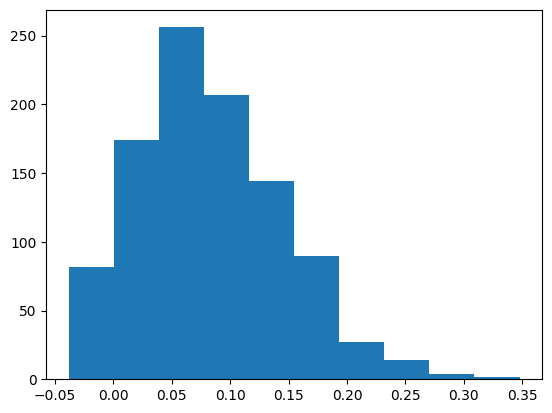

In [33]:
plt.clf()
plt.hist(xs)
plt.show()

In [34]:


# make a fake prior

prior_low = [0, jnp.pi / 1000, 0, 0, 0]
prior_high = [10, jnp.pi / 10, 20, 20, 4]

prior = sbi.utils.BoxUniform(low=torch.tensor(prior_low), high=torch.tensor(prior_high), device='cpu')

posterior = train.train_SBI_hierarchical(thetas, xs, prior)

 Neural network successfully converged after 158 epochs.

In [40]:
# gotta simulate
L_true = 5
theta_not_true = jnp.pi / 100
mu_true = 10
sigma_true = 1

thetas_in = [L_true, theta_not_true, mu_true, sigma_true]

a_g_true, x_true = save_thetas_and_xs_single(thetas_in)
thetas_true = [L_true, theta_not_true, a_g_true, mu_true, sigma_true]

In [41]:
# gotta sample from the posterior
samples = posterior.set_default_x(x_true).sample((10000,))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

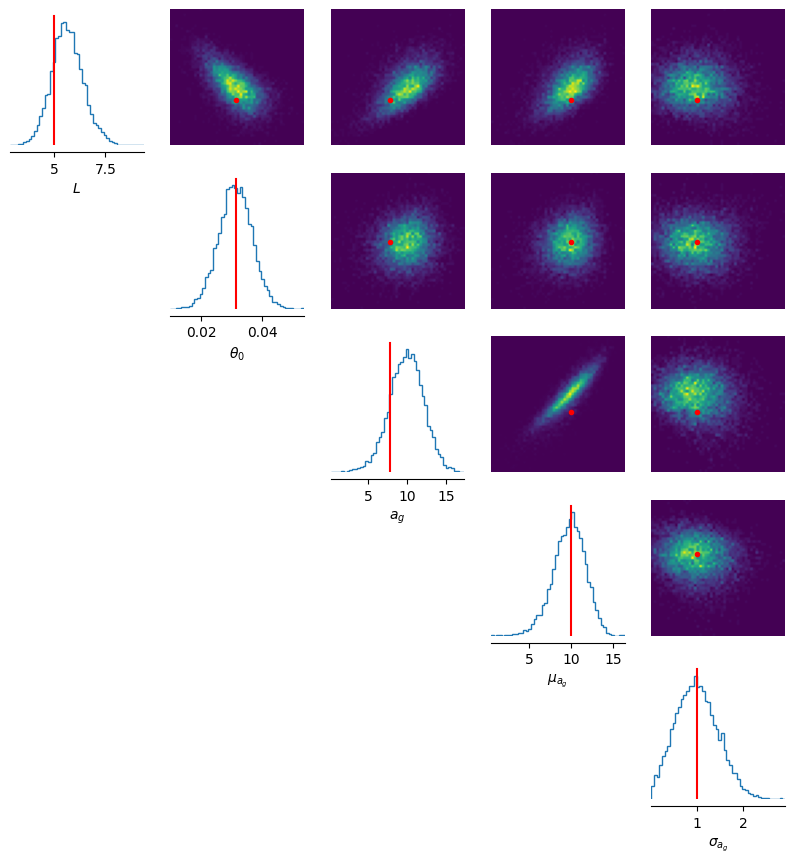

In [42]:
# Let's plot a corner plot.
fig, ax = sbi.analysis.pairplot(samples.cpu(),
                   points=[thetas_true],
                   labels=[r'$L$',r'$\theta_0$',r'$a_g$',r'$\mu_{a_g}$',r'$\sigma_{a_g}$'],
                   #limits=limits,
                   points_colors=['r','b'],
                   points_offdiag={'markersize': 6},
                   fig_size=[12, 12])

plt.show()